# Loan Default Risk Prediction — Logistic Regression Baseline

This notebook builds an interpretable Logistic Regression baseline for loan default prediction.
The primary goal is to understand feature behavior and the role of missing values before
moving to more complex tree-based models.


In [260]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [262]:
df=pd.read_csv("application_train.csv")

In [258]:
df['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [18]:
df.shape

(307511, 122)

In [19]:
df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [20]:
df.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [21]:
df['AMT_ANNUITY'].isnull().sum()

12

<Axes: xlabel='AMT_ANNUITY', ylabel='Count'>

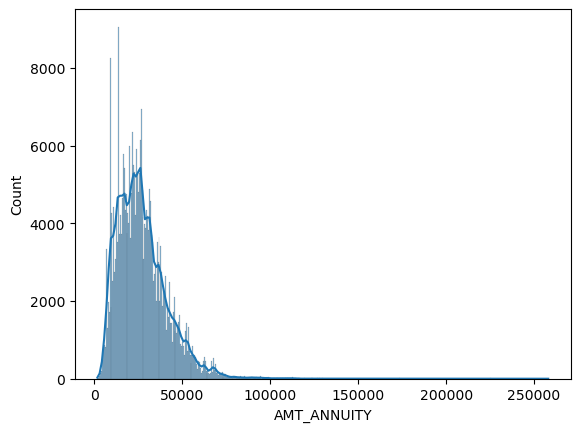

In [22]:
sns.histplot(df['AMT_ANNUITY'],kde=True)

In [23]:
df['AMT_ANNUITY'].skew()

1.5797773638612507

In [24]:
percent=(df.isnull().sum()/df.shape[0])*100

In [25]:
percent_sorted = percent.sort_values(ascending=False)


In [26]:
b1=[]
b2=[] 
b3=[]
b4=[]
for i in percent_sorted.index: 
    if percent_sorted[i]<5:
        b1.append(i)
    elif percent_sorted[i]>=5 and percent_sorted[i]<30:
        b2.append(i)
    elif percent_sorted[i]>=30 and percent_sorted[i]<60:
        b3.append(i) 
    elif percent_sorted[i]>=60:
        b4.append(i)

In [27]:
len(b1), len(b2), len(b3), len(b4)


(65, 7, 33, 17)

**Missing Value Analysis**

To understand the quality of the dataset, features were grouped based on the percentage of missing values.

- **0–5% missing (65 features)**  
  Most features are nearly complete and form a **stable foundation** for baseline modeling.

- **5–30% missing (7 features)**  
  A small but important set of features. These often carry **strong predictive signal** and will be handled using **imputation along with missing-value indicators**.

- **30–60% missing (33 features)**  
  A significant portion of the dataset. These features require **case-by-case evaluation**, as some may be highly informative while others may introduce noise.

- **>60% missing (17 features)**  
  Expected in real-world credit data. Most of these features will likely be **dropped**, except those with clear business relevance or proven predictive value.

Overall, the missing-value distribution confirms that the dataset is **realistic, non-trivial, and suitable for a professional loan default risk prediction project**.


In [29]:
# Separate target
y = df['TARGET']
X = df.drop(columns=['TARGET', 'SK_ID_CURR'])


In [31]:
X.shape, y.shape


((307511, 120), (307511,))

In [32]:
cat_cols=X.select_dtypes(include='object').columns.tolist()
num_cols=X.select_dtypes(exclude='object').columns.tolist()

In [33]:
len(cat_cols), len(num_cols)

(16, 104)

## Preprocessing Strategy

The dataset contains numerical and categorical features with meaningful missing values.

Strategy used:
- Numerical features: imputation + missing indicator
- Categorical features: imputation + one-hot encoding
- Explicit missing indicators are added to allow the model to learn
  whether missingness itself is predictive of default risk


In [35]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler

## Baseline Logistic Regression (Without Missing Indicators)

In [37]:
# num ->imputer,scaler cat->imputer,OHE
num_pipeline=Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),('scaler',StandardScaler())
])
cat_pipeline=Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),('ohe',OneHotEncoder(handle_unknown='ignore'))
])
trf=ColumnTransformer(transformers=[
    ('num',num_pipeline,num_cols),
    ('cat',cat_pipeline,cat_cols)
])

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
X_train,X_test,y_train,y_test=train_test_split(X,y, stratify=y,random_state=42,train_size=0.8)

In [39]:
# for larger dataset always use max_iteration parameter and solver=lbfgs
lr_model=Pipeline(steps=[
    ('preprocessing',trf), 
    ('LR',LogisticRegression(max_iter=500,solver='lbfgs'))
])

In [40]:
lr_model.fit(X_train,y_train)

,steps,"[('preprocessing', ...), ('LR', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [41]:
y_pred_lr=lr_model.predict(X_test)
roc_auc=roc_auc_score(y_test,y_pred_lr)
print("ROC AUC Score is:",roc_auc)


ROC AUC Score is: 0.5056443336401611


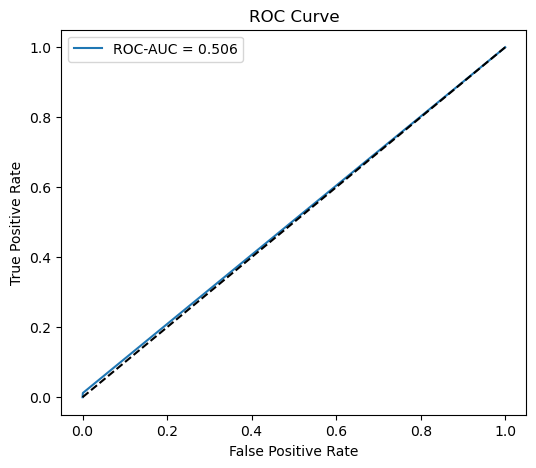

In [42]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_lr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


## Logistic Regression with Missing Indicators for B2

In [44]:
num_b2 = [col for col in b2 if col in num_cols]
num_rest = [col for col in num_cols if col not in num_b2]

In [45]:
num_b2_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
    ('scaler', StandardScaler())
]) 
num_rest_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
]) 
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

In [46]:
preprocessor_v2 = ColumnTransformer(transformers=[
    ('num_b2', num_b2_pipeline, num_b2),
    ('num_rest', num_rest_pipeline, num_rest),
    ('cat', cat_pipeline, cat_cols)
])


In [47]:

lr_model_v2 = Pipeline(steps=[
    ('preprocessing', preprocessor_v2),
    ('lr', LogisticRegression(
        max_iter=1000,
        solver='lbfgs',
        n_jobs=-1
    ))
])

In [48]:
lr_model_v2.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('lr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_b2', ...), ('num_rest', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [49]:
y_pred_proba = lr_model_v2.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_proba)

0.74918236776969

A baseline logistic regression performed at chance level.
By analyzing missing-value patterns and adding missing-indicator features for moderately sparse variables, ROC-AUC improved to 0.74, demonstrating that missingness carried strong predictive signal.

## Evaluating High-Missingness Columns (b4 Features)

In [52]:
X_reduced = X.drop(columns=b4)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reduced,
    y,
    stratify=y,
    random_state=42,
    train_size=0.8
)

In [53]:
cat_cols_r = X_reduced.select_dtypes(include='object').columns.tolist()
num_cols_r = X_reduced.select_dtypes(exclude='object').columns.tolist()

num_b2_r = [c for c in b2 if c in num_cols_r]
num_rest_r = [c for c in num_cols_r if c not in num_b2_r]


In [54]:
num_b2_pipeline_r = Pipeline([
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
    ('scaler', StandardScaler())
])

num_rest_pipeline_r = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline_r = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])


In [55]:
preprocessor_r = ColumnTransformer(transformers=[
    ('num_b2', num_b2_pipeline_r, num_b2_r),
    ('num_rest', num_rest_pipeline_r, num_rest_r),
    ('cat', cat_pipeline_r, cat_cols_r)
])


In [56]:
lr_model_v3 = Pipeline(steps=[
    ('preprocessing', preprocessor_r),
    ('lr', LogisticRegression(
        max_iter=1000,
        solver='lbfgs',
        n_jobs=-1
    ))
])
lr_model_v3.fit(X_train_r, y_train_r)
y_pred_proba_v3 = lr_model_v3.predict_proba(X_test_r)[:, 1]


In [57]:
roc_auc_score(y_test_r, y_pred_proba_v3)

0.7490225273187383

Thus b4 can be dropeed

## Validating the Missing-Indicator Hypothesis

In [60]:
lr_model_v3

,steps,"[('preprocessing', ...), ('lr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_b2', ...), ('num_rest', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [61]:
lr=lr_model_v3.named_steps['lr']

In [63]:
feature_names = lr_model_v3.named_steps[
    'preprocessing'
].get_feature_names_out()


In [64]:
import pandas as pd

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': lr.coef_[0]
})

coef_df['abs_coef'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False)


In [65]:
coef_df.head(20)


,feature,coefficient,abs_coef
18,num_rest__AMT_GOODS_PRICE,-1.008412,1.008412
16,num_rest__AMT_CREDIT,0.922046,0.922046
215,cat__ORGANIZATION_TYPE_Transport: type 3,0.719035,0.719035
192,cat__ORGANIZATION_TYPE_Military,-0.612494,0.612494
0,num_b2__EXT_SOURCE_3,-0.492377,0.492377
197,cat__ORGANIZATION_TYPE_Realtor,0.485574,0.485574
21,num_rest__DAYS_EMPLOYED,0.451559,0.451559
195,cat__ORGANIZATION_TYPE_Police,-0.426527,0.426527
97,cat__CODE_GENDER_F,-0.423178,0.423178
202,cat__ORGANIZATION_TYPE_Security Ministries,-0.400396,0.400396


In [126]:
# Mostly positive coefficients ->Missingness carries predictive signal
coef_df[coef_df['feature'].str.contains('missing', case=False)].head(10)

,feature,coefficient,abs_coef
9,num_b2__missingindicator_AMT_REQ_CREDIT_BUREAU...,0.018614,0.018614
13,num_b2__missingindicator_AMT_REQ_CREDIT_BUREAU...,0.018614,0.018614
10,num_b2__missingindicator_AMT_REQ_CREDIT_BUREAU...,0.018614,0.018614
8,num_b2__missingindicator_AMT_REQ_CREDIT_BUREAU...,0.018614,0.018614
12,num_b2__missingindicator_AMT_REQ_CREDIT_BUREAU...,0.018614,0.018614
11,num_b2__missingindicator_AMT_REQ_CREDIT_BUREAU...,0.018614,0.018614
7,num_b2__missingindicator_EXT_SOURCE_3,0.008531,0.008531


In [128]:
# drop dublicates
missing_df_clean = (
    coef_df[coef_df['feature'].str.contains('missing', case=False)]
    .sort_values('abs_coef', ascending=False)
    .drop_duplicates(subset='feature')
)

missing_df_clean


,feature,coefficient,abs_coef
9,num_b2__missingindicator_AMT_REQ_CREDIT_BUREAU...,0.018614,0.018614
13,num_b2__missingindicator_AMT_REQ_CREDIT_BUREAU...,0.018614,0.018614
10,num_b2__missingindicator_AMT_REQ_CREDIT_BUREAU...,0.018614,0.018614
8,num_b2__missingindicator_AMT_REQ_CREDIT_BUREAU...,0.018614,0.018614
12,num_b2__missingindicator_AMT_REQ_CREDIT_BUREAU...,0.018614,0.018614
11,num_b2__missingindicator_AMT_REQ_CREDIT_BUREAU...,0.018614,0.018614
7,num_b2__missingindicator_EXT_SOURCE_3,0.008531,0.008531


## Business Interpretation of Key Features

**Feature:** missingindicator_AMT_REQ_CREDIT_BUREAU  
**Direction:** Increases default risk  
**Reason:** Missing credit bureau request history often indicates thin or unverifiable credit profiles  
**Business Interpretation:** Applicants with missing bureau history should be treated as higher risk and may require stricter underwriting

**Feature:** EXT_SOURCE_3  
**Direction:** Decreases default risk  
**Reason:** Higher external credit scores indicate stronger repayment behavior  
**Business Interpretation:** External scores can be trusted as a strong risk-reducing signal

**Feature:** AMT_CREDIT  
**Direction:** Increases default risk  
**Reason:** Larger loan amounts increase repayment burden  
**Business Interpretation:** High credit exposure should be evaluated relative to income

## Conclusion

The baseline Logistic Regression model failed to capture important risk patterns.
Introducing missing indicators significantly improved performance, confirming that
missingness itself is predictive in credit risk modeling.
Low-signal b4 features were safely removed without degrading performance.
The model learned interpretable and domain-consistent patterns.
This provides a strong foundation for moving to more powerful tree-based models.


# Tree-Based Models for Performance Improvement

In [142]:
from sklearn.ensemble import RandomForestClassifier

In [150]:
num_b2_pipeline_r = Pipeline([
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
    ('scaler', StandardScaler())
])

num_rest_pipeline_r = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline_r = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_r = ColumnTransformer(transformers=[
    ('num_b2', num_b2_pipeline_r, num_b2_r),
    ('num_rest', num_rest_pipeline_r, num_rest_r),
    ('cat', cat_pipeline_r, cat_cols_r)
])


In [154]:
rf_model= Pipeline(steps=[
    ('preprocessing', preprocessor_r),
    ('random forest',RandomForestClassifier(
            n_estimators=50,        # ↓ from 100 (enough for baseline)
    max_depth=12,           # limit depth (huge speed + less overfitting)
    min_samples_leaf=50,    # prevents deep noisy splits
    n_jobs=-1,              # use all CPU cores
    random_state=42,
    class_weight='balanced' # good for credit default
    ))
])
rf_model.fit(X_train_r, y_train_r)
y_pred_proba= rf_model.predict_proba(X_test_r)[:, 1]

In [158]:
roc_auc_score(y_test_r,y_pred_proba)

0.7374547368385804

In [160]:
from xgboost import XGBClassifier


In [162]:
xg_model= Pipeline(steps=[
    ('preprocessing', preprocessor_r),
     ('XG boosting',XGBClassifier())
])
xg_model.fit(X_train_r, y_train_r)
y_pred_proba_xg= xg_model.predict_proba(X_test_r)[:, 1]

In [164]:
roc_auc_score(y_test_r,y_pred_proba_xg)

0.7519638887187852

In [166]:
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    tree_method='hist',        # FAST for large datasets
    n_jobs=-1,
    random_state=42
)


In [168]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor_r),
    ('xgb', xgb_clf)
])


In [170]:
param_dist = {
    'xgb__n_estimators': [200, 300, 400],
    'xgb__max_depth': [3, 4, 5, 6],
    'xgb__learning_rate': [0.05, 0.1, 0.2],
    'xgb__subsample': [0.7, 0.8, 1.0],
    'xgb__colsample_bytree': [0.7, 0.8, 1.0],
    'xgb__scale_pos_weight': [1, 3, 5]  # IMPORTANT for imbalance
}


In [174]:
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_dist,
    n_iter=10,                # DO NOT increase blindly
    scoring='roc_auc',
    cv=3,                     # 5 is too slow for your data
    verbose=2,
    random_state=42,
    n_jobs=1                  # IMPORTANT: avoid nested parallelism
)


In [176]:
random_search.fit(X_train_r, y_train_r)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:19:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__scale_pos_weight=1, xgb__subsample=1.0; total time=  13.9s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:19:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__scale_pos_weight=1, xgb__subsample=1.0; total time=  13.9s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:20:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__scale_pos_weight=1, xgb__subsample=1.0; total time=  13.1s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:20:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.7, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__scale_pos_weight=5, xgb__subsample=0.8; total time=  15.9s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:20:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.7, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__scale_pos_weight=5, xgb__subsample=0.8; total time=  16.2s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:20:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.7, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__scale_pos_weight=5, xgb__subsample=0.8; total time=  16.0s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:21:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=400, xgb__scale_pos_weight=1, xgb__subsample=0.7; total time=  19.1s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:21:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=400, xgb__scale_pos_weight=1, xgb__subsample=0.7; total time=  19.9s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:21:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=400, xgb__scale_pos_weight=1, xgb__subsample=0.7; total time=  19.4s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:22:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__n_estimators=400, xgb__scale_pos_weight=5, xgb__subsample=1.0; total time=  15.7s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:22:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__n_estimators=400, xgb__scale_pos_weight=5, xgb__subsample=1.0; total time=  15.9s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:22:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__n_estimators=400, xgb__scale_pos_weight=5, xgb__subsample=1.0; total time=  15.5s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:22:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=400, xgb__scale_pos_weight=3, xgb__subsample=1.0; total time=  17.4s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:23:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=400, xgb__scale_pos_weight=3, xgb__subsample=1.0; total time=  17.2s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:23:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=400, xgb__scale_pos_weight=3, xgb__subsample=1.0; total time=  17.9s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:23:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=400, xgb__scale_pos_weight=3, xgb__subsample=0.8; total time=  19.5s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:24:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=400, xgb__scale_pos_weight=3, xgb__subsample=0.8; total time=  19.5s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:24:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=400, xgb__scale_pos_weight=3, xgb__subsample=0.8; total time=  19.6s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:24:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.7, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=200, xgb__scale_pos_weight=5, xgb__subsample=0.8; total time=  18.0s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:25:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.7, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=200, xgb__scale_pos_weight=5, xgb__subsample=0.8; total time=  14.4s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:25:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.7, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=200, xgb__scale_pos_weight=5, xgb__subsample=0.8; total time=  13.3s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:25:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.7, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=300, xgb__scale_pos_weight=1, xgb__subsample=0.8; total time=  16.0s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:25:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.7, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=300, xgb__scale_pos_weight=1, xgb__subsample=0.8; total time=  15.5s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:26:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.7, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=300, xgb__scale_pos_weight=1, xgb__subsample=0.8; total time=  15.4s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:26:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=400, xgb__scale_pos_weight=3, xgb__subsample=0.8; total time=  19.0s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:26:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=400, xgb__scale_pos_weight=3, xgb__subsample=0.8; total time=  19.1s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:27:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=400, xgb__scale_pos_weight=3, xgb__subsample=0.8; total time=  19.0s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:27:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=400, xgb__scale_pos_weight=5, xgb__subsample=0.8; total time=  15.5s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:27:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=400, xgb__scale_pos_weight=5, xgb__subsample=0.8; total time=  16.5s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:27:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=400, xgb__scale_pos_weight=5, xgb__subsample=0.8; total time=  16.2s


C:\Users\princ\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:28:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'xgb__colsample_bytree': [0.7, 0.8, ...], 'xgb__learning_rate': [0.05, 0.1, ...], 'xgb__max_depth': [3, 4, ...], 'xgb__n_estimators': [200, 300, ...], ...}"
,n_iter,10
,scoring,'roc_auc'
,n_jobs,1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [188]:
best_model=random_search.best_estimator_
y_pred_proba_xg_best_model = best_model.predict_proba(X_test_r)[:, 1] 
roc_auc_score(y_test_r,y_pred_proba_xg_best_model)

0.7610707849637761

# Feature Importance 

In [205]:
xgb_model=best_model.named_steps['xgb']
feature_names=best_model.named_steps['preprocessing'].get_feature_names_out()

In [215]:
feature_importance_df=pd.DataFrame({"feature":feature_names,"importance":xgb_model.feature_importances_}).sort_values(by='importance',ascending=False)
feature_importance_df.head(15)

,feature,importance
41,num_rest__EXT_SOURCE_2,0.092843
0,num_b2__EXT_SOURCE_3,0.073486
120,cat__NAME_EDUCATION_TYPE_Higher education,0.065917
118,cat__NAME_INCOME_TYPE_Working,0.037807
97,cat__CODE_GENDER_F,0.032562
76,num_rest__FLAG_DOCUMENT_3,0.029486
98,cat__CODE_GENDER_M,0.026312
65,num_rest__FLOORSMAX_MEDI,0.020387
8,num_b2__missingindicator_AMT_REQ_CREDIT_BUREAU...,0.019910
40,num_rest__EXT_SOURCE_1,0.019579


Feature importance analysis shows that external credit bureau scores (EXT_SOURCE_1/2/3)
are the most influential predictors of loan default. Socio-economic indicators such as
education level and income type also play a significant role. Importantly, missing-indicator
features related to credit bureau information remain influential, confirming that missingness
itself is predictive of risk. These findings are consistent across linear and tree-based models,
increasing confidence in model reliability.


# Shap

In [221]:
import shap

In [223]:
X_sample = X_train_r.sample(5000, random_state=42)

In [225]:
preprocessor = best_model.named_steps['preprocessing']
xgb_model = best_model.named_steps['xgb']

In [227]:
X_sample_transformed = preprocessor.transform(X_sample)

feature_names = preprocessor.get_feature_names_out()

In [229]:
explainer = shap.TreeExplainer(xgb_model)


In [231]:
shap_values = explainer.shap_values(X_sample_transformed)


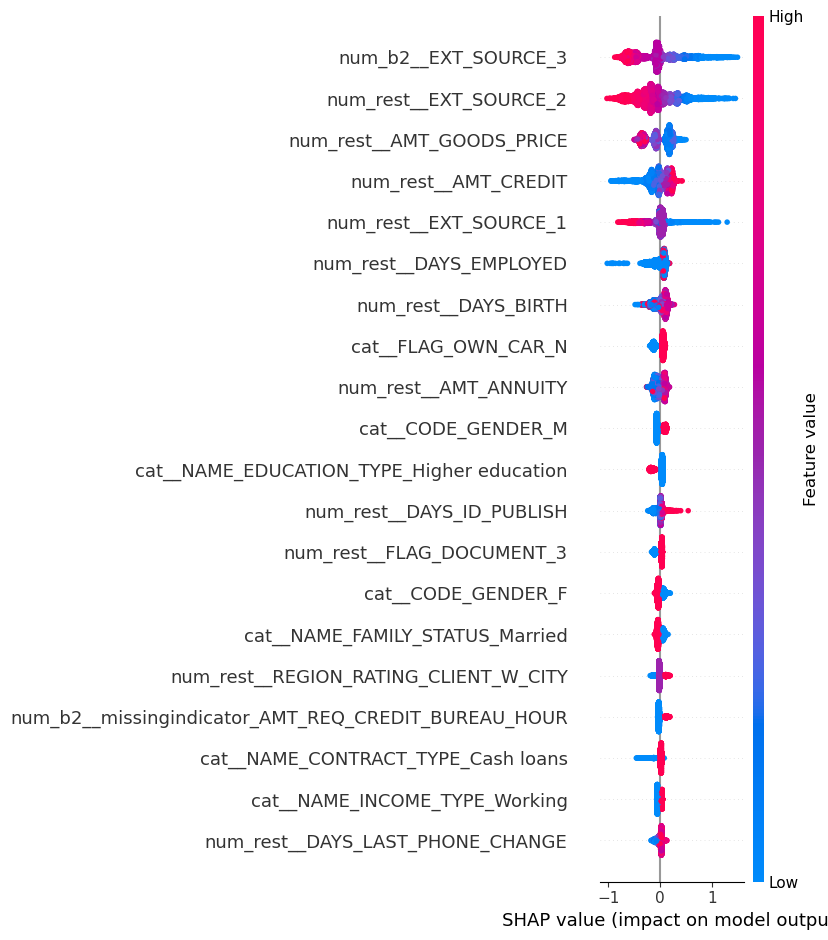

In [233]:
shap.summary_plot(
    shap_values,
    X_sample_transformed,
    feature_names=feature_names,
    show=True
)


In [235]:
import joblib
joblib.dump(
    best_model,
    "xgboost_credit_risk_pipeline.joblib"
)


['xgboost_credit_risk_pipeline.joblib']

In [237]:
loaded_model=joblib.load('xgboost_credit_risk_pipeline.joblib')

In [239]:
loaded_model.predict_proba(X_test_r)[:, 1][:5]


array([0.04551629, 0.04009095, 0.24868286, 0.06825276, 0.08490691],
      dtype=float32)

The final trained pipeline, including preprocessing and the tuned XGBoost model,
was serialized using joblib. This enables consistent reuse of the model for
deployment or batch inference without preprocessing discrepancies.


In [ ]:
df['']